In [2]:
import shutil

zip_path = "/content/archive.zip"  # Zip dosyasının konumu
extract_to = "/content/eski-veri-seti-snf-karm"  # Çıkartılacak hedef klasör

shutil.unpack_archive(zip_path, extract_to)

print("✅ Dosya başarıyla çıkartıldı!")


✅ Dosya başarıyla çıkartıldı!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Ana veri dizini ve hedef dizinleri tanımla
base_dir = "/content/eski-veri-seti-snf-karm"
output_dir = "/content/split_dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Oranları belirle
test_size = 0.2

# Mevcut dizinleri temizle ve yeniden oluştur
for folder in [train_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Her bir sınıfı ayrı ayrı işle
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Görselleri listele ve train/test olarak ayır
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Hedef klasörleri oluştur
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Görselleri ilgili klasörlere KOPYALA
    for img in train_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in test_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("✅ Veri başarıyla train/test olarak bölündü.")


✅ Veri başarıyla train/test olarak bölündü.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/content/split_dataset/train"
test_dir = "/content/split_dataset/test"
img_size = (224, 224)
batch_size = 64
epochs = 10 # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 5110 files belonging to 8 classes.
Found 1282 files belonging to 8 classes.


In [5]:
# VGG16 modelini yükle (transfer öğrenme)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_model.keras', save_best_only=True, monitor='val_accuracy')


# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3270 - loss: 4.2828 - val_accuracy: 0.4906 - val_loss: 1.4058
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4651 - loss: 1.5089 - val_accuracy: 0.4922 - val_loss: 1.3428
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4787 - loss: 1.4103 - val_accuracy: 0.5094 - val_loss: 1.3072
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4737 - loss: 1.3994 - val_accuracy: 0.5156 - val_loss: 1.2954
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5135 - loss: 1.3234 - val_accuracy: 0.5242 - val_loss: 1.2758
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5007 - loss: 1.3285 - val_accuracy: 0.5257 - val_loss: 1.2581
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5125 - loss: 1.2983 - val_accuracy: 0.5257 - val_loss: 1.2421
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5205 - loss: 1.2788 - val_accuracy: 0.5312 - val_

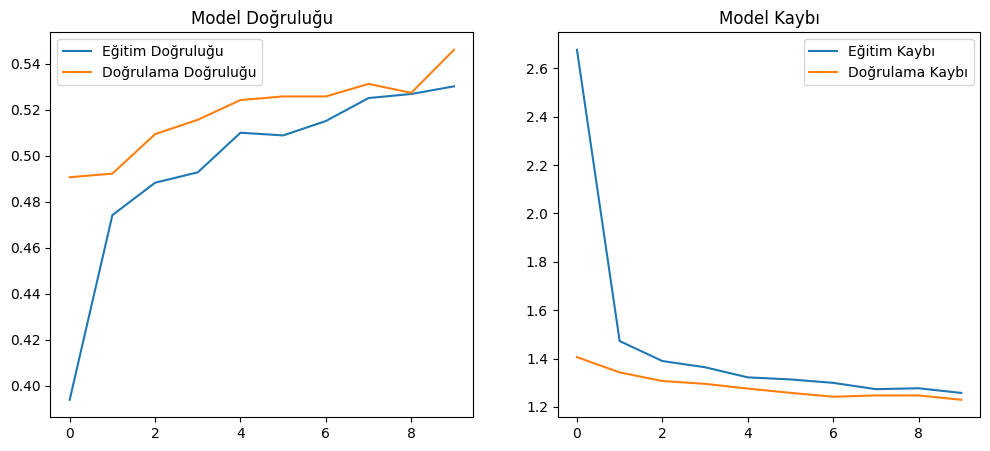

In [7]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.74      0.73      0.74    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
